In [1]:
import warnings
warnings.filterwarnings("ignore")

import sys
sys.path.append("../src")
sys.path.append("../data")

import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import pprint as pp

import sindy_utils
from sindy_data import generate_system_from_dynamics
from dynamics import Exp2D
from dynamics import Lorenz
from dynamics import SimplePendulum

from sindy import SINDy, SINDy_LSQ
from sindy_algorithms import STLSQ
from sindy_libs import PolynomialLibrary, TrigLibrary

In [2]:
def simulate_system(system, init_conditions, t0, tf, steps):
    return generate_system_from_dynamics(
        system.f,
        init_conditions = init_conditions,
        t0=t0,
        tf=tf,
        steps=steps,
        equations=system.equations
    )

In [3]:
lorenz = simulate_system(
    Lorenz(),
    (0, 1, 1.05),
    0,
    40,
    100000
)

lorenz.show()


initial conditions: (0, 1, 1.05)

equations:
(x)' = 10(y - x)
(y)' = x(28 - z) - y
(z)' = xy - 2.667z



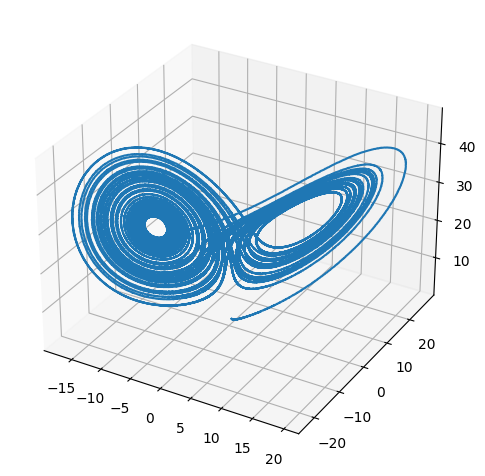

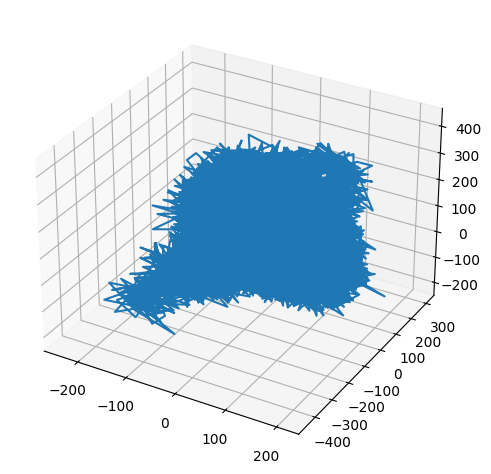

In [30]:
X, X_dot, t = lorenz.time_series()

X_train = sindy_utils.add_noise(X, amount=0.1)
# sindy_utils.plot(X_train)

X_dot_train = sindy_utils.differentiate(X_train,t)
sindy_utils.plot(X_train)
sindy_utils.plot(X_dot_train)

In [33]:
model = SINDy_LSQ(
    libs=[
        PolynomialLibrary(max_degree=3),
        TrigLibrary()
    ],
    feature_names=['x','y','z'],
    algo=STLSQ(threshold=0.2, reg=1)
)

model.fit(X_train, X_dot_train)
lorenz.show()
model.show()


initial conditions: (0, 1, 1.05)

equations:
(x)' = 10(y - x)
(y)' = x(28 - z) - y
(z)' = xy - 2.667z

(x)' = -10.004 x + 10.004 y
(y)' = 27.821 x + -0.964 y + -0.994 x z
(z)' = -2.667 z + 0.999 x y


In [63]:
pendulum = simulate_system(
    SimplePendulum(g=9.8, l=4, mu=0),
    (np.pi/2, 0),
    0,
    10,
    10000
)

pendulum.show()


initial conditions: (1.5707963267948966, 0)

equations:
(θ)'     = θ_dot
(θ_dot)' = -9.8/4 * sin(θ) - 0 * θ_dot



In [65]:
X, X_dot, t = pendulum.time_series()

In [69]:
model = SINDy_LSQ(
    libs=[
        PolynomialLibrary(max_degree=2),
        TrigLibrary()
    ],
    feature_names=['θ', 'θ_dot'],
    algo=STLSQ(threshold=0, reg=0)
)

model.fit(X, X_dot)
model.show()

(θ)' = 0.45 1 + 1.0 θ_dot + -0.256 θ^2 + 0.066 θ_dot^2 + -0.664 cos(θ) + 0.182 cos(θ_dot)
(θ_dot)' = 0.214 1 + -0.121 θ^2 + 0.031 θ_dot^2 + -2.45 sin(θ) + -0.316 cos(θ) + 0.085 cos(θ_dot)
